# Spatial Correlation Analysis of Uncertainty Heatmaps

In this notebook we apply common spatial correlation metrics used for greyscale images to uncertainty heatmaps.

Goals:
- Extract meaningful scores reflecting spatial correlation of uncertainty values: Noise vs Structure, "Local vs Global Uncertainty", etc.
- Apply these metrics to toy data and real uncertainty maps, compare them and assess their reliability in practice.

Metrics:
- Moran's I
- Geary's C
- Grey-level Co-occurence Matrix (GLCM)

Note: For GLCM, we consider its correlation component. However, this is almost identical to Moran's I (for the choice of radius=1 and angle=0). Hence we will focus more on Moran's I.

In [39]:
# Firstly, we import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from aggrigator.uncertainty_maps import UncertaintyMap
from aggrigator.methods import AggregationMethods as am
from aggrigator.summary import AggregationSummary
from aggrigator.strategylist import StrategyList
from aggrigator.util import generate_disk_bdry_mask, generate_disk_mask
from aggrigator.datasets import generate_binary_quadrant_array, generate_checkerboard_array

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic Example

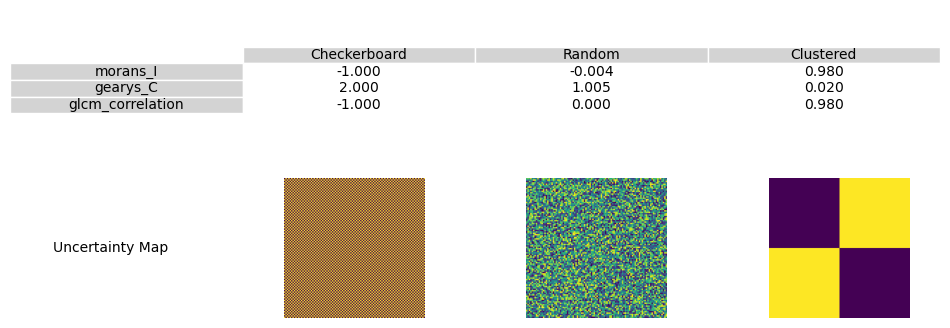

In [27]:
size = 100
array_1 = generate_checkerboard_array(size)
unc_map_1 = UncertaintyMap(array=array_1, mask=None, name="Checkerboard")

array_2 = np.random.random((100,100))
unc_map_2 = UncertaintyMap(array=array_2, mask=None, name="Random")

array_3 = generate_binary_quadrant_array(size)
unc_map_3 = UncertaintyMap(array=array_3, mask=None, name="Clustered")

summary = AggregationSummary(StrategyList.SPATIAL)
result = summary.apply_methods([unc_map_1, unc_map_2, unc_map_3], save_to_excel=False, do_plot=True, max_value=1.0)

# Analysis of Arctique Heatmaps

In [11]:
def get_arctique_slice_arrays(slice, dataset):
    # Load arrays
    path = os.path.join(os.getcwd(), "..", "..", "data", dataset)
    files = os.listdir(path)
    arrays = [np.load(os.path.join(path, file)) for file in files] # 3D arrays, shape (50,512,512)
    if len(arrays[0].shape) == 3:
        arrays = [array[slice,:,:] for array in arrays]
    arrays = [np.where(array < 0, 0, array) for array in arrays]
    return arrays, files

In [12]:
# Get spatial aggregation summary
SLICE = 25
DATASET = "arctique_uq_maps"

arrays, filenames = get_arctique_slice_arrays(SLICE, DATASET)
unc_maps = [UncertaintyMap(array=array, mask=None, name=name) for array, name in zip(arrays, filenames)]
strategy_list = [(am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None), (am.mean, None)]

summary = AggregationSummary(strategy_list, name=f"spatial_analysis_{DATASET}_slice_{SLICE}", num_cpus=12)
spatial_df = summary.apply_methods(unc_maps, save_to_excel=False, do_plot=False, max_value=1.0)
spatial_df

Using 8 CPUs.


Name  instance_noise_0_blood_cells_0_00_dropout_au.npy  \
0          gearys_C                                          0.097541   
1          morans_I                                          0.902148   
2  glcm_correlation                                          0.900985   
3              mean                                          0.268395   

   instance_noise_0_blood_cells_0_00_dropout_eu.npy  \
0                                          0.102406   
1                                          0.898254   
2                                          0.890118   
3                                          0.008570   

   instance_noise_0_blood_cells_0_00_dropout_pu.npy  \
0                                          0.097528   
1                                          0.902181   
2                                          0.900982   
3                                          0.270142   

   instance_noise_0_blood_cells_0_00_ensemble_au.npy  \
0                                           0.099213   
1                                           0.899453   
2                                           0.902360   
3                                           0.172245   

   instance_noise_0_blood_cells_0_00_ensemble_eu.npy  \
0                                           0.215318   
1                                           0.785725   
2                                           0.770563   
3                                           0.010298   

   instance_noise_0_blood_cells_0_00_ensemble_pu.npy  \
0                                           0.099348   
1                                           0.899329   
2                                           0.902196   
3                                           0.172488   

   instance_noise_0_blood_cells_0_00_softmax_pu.npy  \
0                                          0.166413   
1                                          0.832116   
2                                          0.836809   
3                                          0.110712   

   instance_noise_0_blood_cells_0_00_tta_au.npy  \
0                                      0.079408   
1                                      0.920163   
2                                      0.918223   
3                                      0.329533   

   instance_noise_0_blood_cells_0_00_tta_eu.npy  ...  \
0                                      0.076574  ...   
1                                      0.924498  ...   
2                                      0.922026  ...   
3                                      0.061448  ...   

   semantic_noise_0_nuclei_intensity_1_00_dropout_au.npy  \
0                                           0.026575       
1                                           0.972873       
2                                           0.973519       
3                                           0.278149       

   semantic_noise_0_nuclei_intensity_1_00_dropout_eu.npy  \
0                                           0.032613       
1                                           0.967703       
2                                           0.966404       
3                                           0.029762       

   semantic_noise_0_nuclei_intensity_1_00_dropout_pu.npy  \
0                                           0.026609       
1                                           0.972863       
2                                           0.973482       
3                                           0.270671       

   semantic_noise_0_nuclei_intensity_1_00_ensemble_au.npy  \
0                                           0.023966        
1                                           0.975450        
2                                           0.976209        
3                                           0.277710        

   semantic_noise_0_nuclei_intensity_1_00_ensemble_eu.npy  \
0                                           0.080939        
1                                           0.919946        
2                                           0.919

## Plot Edge Case Heatmaps

In [28]:
# Plot 10 unc maps with lowest and highest values
import matplotlib.pyplot as plt

def plot_extremal_heatmaps(arrays, method, N=10):
    method_values = {i: spatial_df[spatial_df["Name"]==method][filenames[i]].values[0] for i in range(len(arrays))}

    vals_sorted_ascending = [idx for idx, val in sorted(method_values.items(), key=lambda x: x[1])]
    min_heatmaps = {i: arrays[i] for i in vals_sorted_ascending[:N]}
    max_heatmaps = {i: arrays[i] for i in vals_sorted_ascending[-N:]}

    fig, axes = plt.subplots(1, N, figsize=(3*N, 3))
    # Plot each image in a separate subplot
    for ax, (idx, img) in zip(axes, min_heatmaps.items()):
        ax.imshow(img, cmap="viridis", vmin=0, vmax=1)  # Plot as grayscale
        ax.axis("off")  # Hide axes for better visualization
        val = f"{method_values[idx]:.3f}"
        ax.text(0.5, -0.15, val, fontsize=12, ha="center", va="center", transform=ax.transAxes)  # Add text
    fig.suptitle(f"{N} minimal heatmaps for {method}", fontsize=16)

    fig, axes = plt.subplots(1, N, figsize=(3*N, 3))
    # Plot each image in a separate subplot
    for ax, (idx, img) in zip(axes, max_heatmaps.items()):
        ax.imshow(img, cmap="viridis", vmin=0, vmax=1)  # Plot as grayscale
        ax.axis("off")  # Hide axes for better visualization
        val = f"{method_values[idx]:.3f}"
        ax.text(0.5, -0.15, val, fontsize=12, ha="center", va="center", transform=ax.transAxes)  # Add text
    fig.suptitle(f"{N} maximal heatmaps for {method}", fontsize=16)

    plt.show()


Moran's I


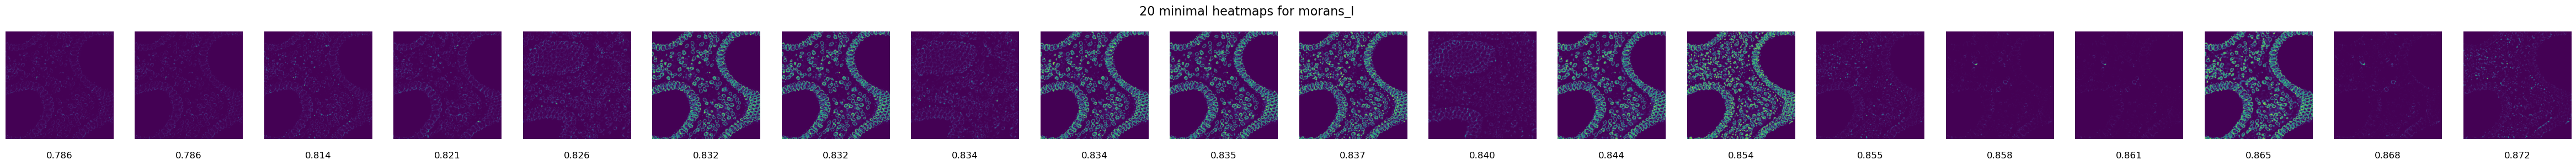

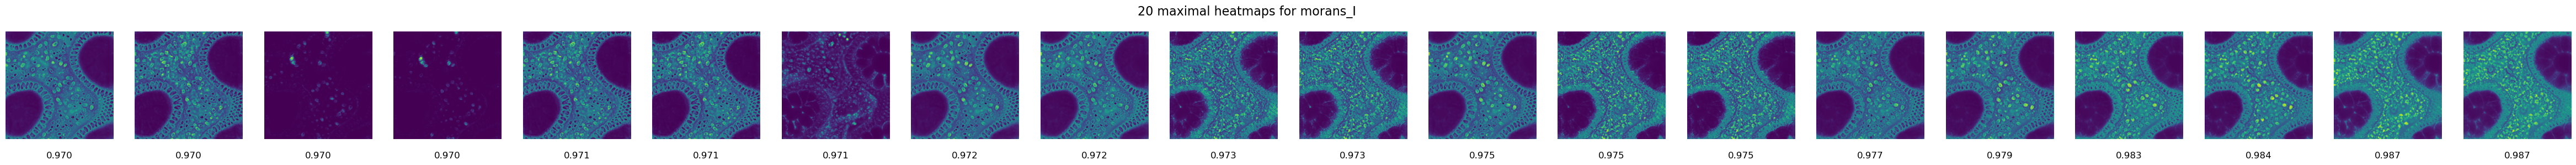

Geary's C


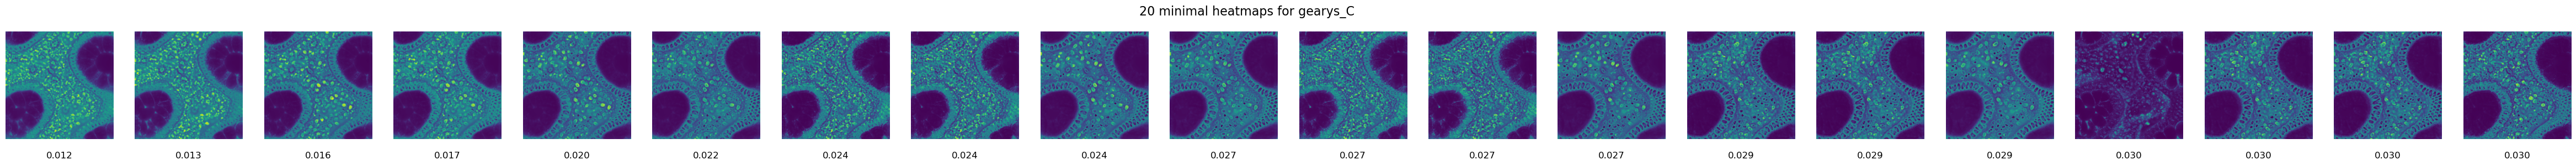

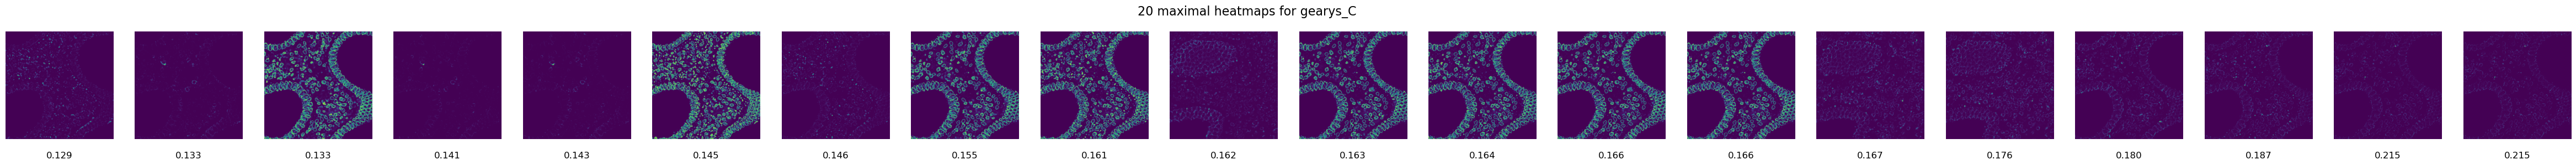

GLCM


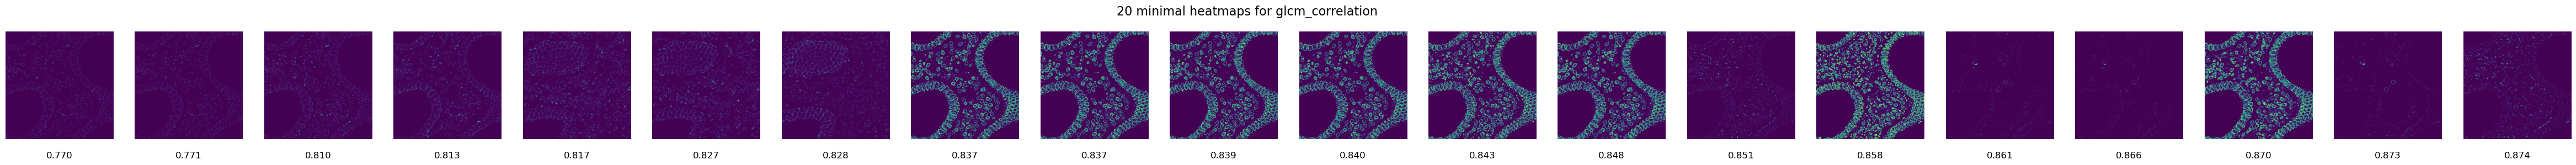

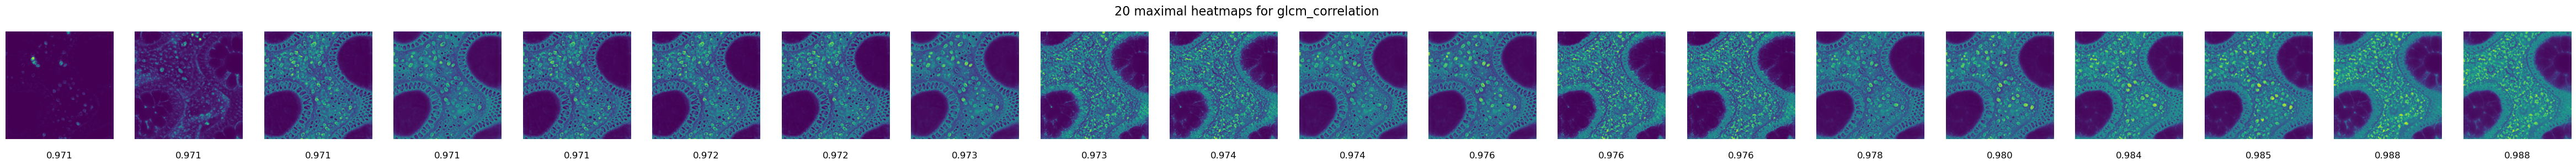

In [29]:
# Moran's I
print("Moran's I")
plot_extremal_heatmaps(arrays, "morans_I", 20)
# Geary's C
print("Geary's C")
plot_extremal_heatmaps(arrays, "gearys_C", 20)
# GLCM
print("GLCM")
plot_extremal_heatmaps(arrays, "glcm_correlation", 20)

## Correlation Matrix

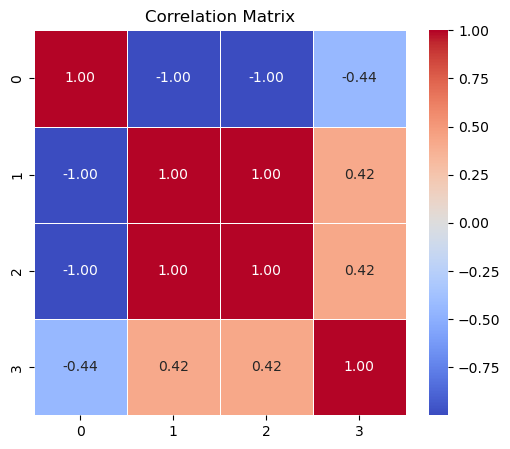

In [30]:
# Compute correlation matrix
df = spatial_df[filenames].T
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

##  Range of Aggregation Scores

For each metric we are interested how well the capture the variety of uncertainty heatmaps present in the dataset.
Ideally, a good score should have a high range of values, indicating its ability to capture qualitative differences across heatmaps.

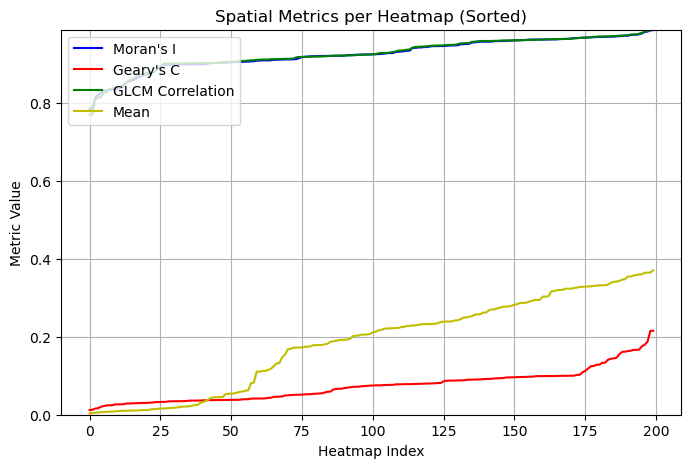

In [31]:
def sort_vals(df, method):
    geary_vals = df[df["Name"]==method].values[:,1:].tolist()[0]
    sorted_indices = np.argsort(geary_vals)  # Indices that would sort geary_vals
    sorted_values = np.array(geary_vals)[sorted_indices]  # Sort values
    return sorted_values

moran_val = sort_vals(spatial_df, "morans_I")
geary_val = sort_vals(spatial_df, "gearys_C")
glcm_val = sort_vals(spatial_df, "glcm_correlation")
mean_val = sort_vals(spatial_df, "mean")
x = [i for i, _ in enumerate(filenames)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, moran_val, linestyle="-", color="b", label="Moran's I")
plt.plot(x, geary_val, linestyle="-", color="r", label="Geary's C")
plt.plot(x, glcm_val, linestyle="-", color="g", label="GLCM Correlation")
plt.plot(x, mean_val, linestyle="-", color="y", label="Mean")
# Labels, title, and legend
plt.xlabel("Heatmap Index")
plt.ylabel("Metric Value")
plt.title("Spatial Metrics per Heatmap (Sorted)")
# Get max y-value for setting the axis limits
max_y = max(max(moran_val), max(geary_val), max(glcm_val))
plt.ylim(0, max_y)  # Set y-axis range
plt.grid(True)
plt.legend(loc="upper left")  # Show legend with appropriate labels
# Show plot
plt.show()


# Counterexamples

Goal: Find heatmaps that have similar mean but different spatial correlation metrics.

In [32]:
method_names = spatial_df["Name"].tolist()
# Sort all columns based on values in the "mean" row
sorted_columns = spatial_df[filenames].loc[method_names.index("mean")].sort_values().index
# Reorder columns in reduced_df (keeping "Name" as the first column)
sorted_df = spatial_df[["Name"]+sorted_columns.tolist()]
sorted_df

Name  instance_noise_0_nuclei_intensity_0_00_dropout_eu.npy  \
0          gearys_C                                           0.141158       
1          morans_I                                           0.860601       
2  glcm_correlation                                           0.865721       
3              mean                                           0.003480       

   instance_noise_0_nuclei_intensity_0_25_dropout_eu.npy  \
0                                           0.143477       
1                                           0.858243       
2                                           0.861332       
3                                           0.004322       

   instance_noise_0_nuclei_intensity_0_50_dropout_eu.npy  \
0                                           0.133287       
1                                           0.868421       
2                                           0.873443       
3                                           0.005272       

   instance_noise_0_blood_cells_0_50_dropout_eu.npy  \
0                                          0.081521   
1                                          0.919522   
2                                          0.918248   
3                                          0.005747   

   instance_noise_0_blood_cells_0_25_dropout_eu.npy  \
0                                          0.085856   
1                                          0.915238   
2                                          0.912868   
3                                          0.006577   

   instance_noise_0_blood_cells_0_75_dropout_eu.npy  \
0                                          0.108729   
1                                          0.893066   
2                                          0.906669   
3                                          0.006627   

   instance_noise_0_blood_cells_1_00_dropout_eu.npy  \
0                                          0.091675   
1                                          0.909630   
2                                          0.909173   
3                                          0.007529   

   semantic_noise_0_nuclei_intensity_0_00_ensemble_eu.npy  \
0                                           0.097042        
1                                           0.904521        
2                                           0.907993        
3                                           0.007884        

   semantic_noise_0_blood_cells_0_00_ensemble_eu.npy  ...  \
0                                           0.096768  ...   
1                                           0.904796  ...   
2                                           0.908314  ...   
3                                           0.007888  ...   

   semantic_noise_0_blood_cells_0_25_tta_pu.npy  \
0                                      0.034495   
1                                      0.962941   
2                                      0.964506   
3                                      0.354537   

   semantic_noise_0_blood_cells_1_00_tta_pu.npy  \
0                                      0.034906   
1                                      0.963119   
2                                      0.963965   
3                                      0.354662   

   semantic_noise_0_blood_cells_0_50_tta_au.npy  \
0                                      0.037508   
1                                      0.959537   
2                                      0.961294   
3                                      0.357123   

   semantic_noise_0_blood_cells_1_00_tta_au.npy  \
0                                      0.037204   
1                                      0.960421   
2                                      0.961519   
3                                      0.358748   

   semantic_noise_0_blood_cells_0_75_tta_au.npy  \
0                                      0.037376   
1                                      0.959988   
2                                      0.961600   
3                                      0.360109   

   semantic_noise_0_blood_

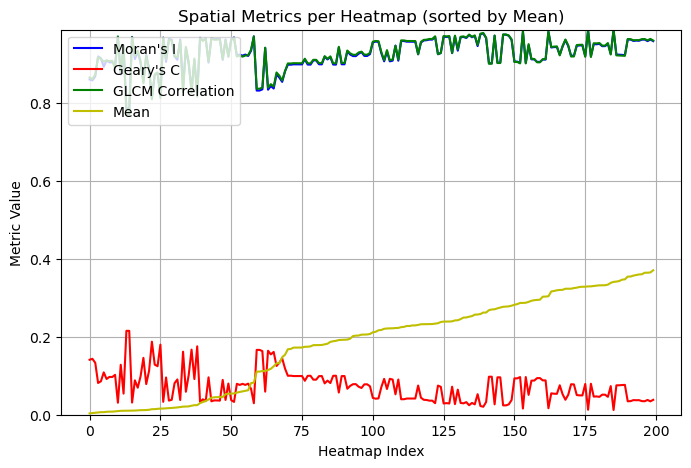

In [33]:
moran_val = list(sorted_df[sorted_columns].loc[method_names.index("morans_I")])
geary_val = list(sorted_df[sorted_columns].loc[method_names.index("gearys_C")])
glcm_val = list(sorted_df[sorted_columns].loc[method_names.index("glcm_correlation")])
mean_val = list(sorted_df[sorted_columns].loc[method_names.index("mean")])
x = [i for i, _ in enumerate(filenames)]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, moran_val, linestyle="-", color="b", label="Moran's I")
plt.plot(x, geary_val, linestyle="-", color="r", label="Geary's C")
plt.plot(x, glcm_val, linestyle="-", color="g", label="GLCM Correlation")
plt.plot(x, mean_val, linestyle="-", color="y", label="Mean")
# Labels, title, and legend
plt.xlabel("Heatmap Index")
plt.ylabel("Metric Value")
plt.title("Spatial Metrics per Heatmap (sorted by Mean)")
# Get max y-value for setting the axis limits
max_y = max(max(moran_val), max(geary_val), max(glcm_val))
plt.ylim(0, max_y)  # Set y-axis range
plt.grid(True)
plt.legend(loc="upper left")  # Show legend with appropriate labels
# Show plot
plt.show()

We see that only Geary's C does have strong variance in values among heatmaps sharing the same mean.
Let us extract heatmaps that have minimal and maximal Geary's C while having similar mean.

In [35]:
# Find a heatmap file that has similar mean (lying between a and b) but different Geary's C
def min_max_heatmap(method, a, b):
    values = sorted_df[filenames].astype(float)
    filtered_columns = values.loc[method_names.index("mean")].between(a, b)
    selected_columns = values.columns[filtered_columns].tolist()
    selected_df = values[selected_columns]

    # Extract row with index 1
    method_row = selected_df.loc[method_names.index(method)]
    # Find column names for min and max values
    min_col = method_row.idxmin()  # Column with min value
    print("Min: ", method_row.min(), min_col)
    max_col = method_row.idxmax()  # Column with max value
    print("Max: ", method_row.max(), max_col)
    return [min_col, max_col]

def sorted_heatmaps_by_mean(method, a, b):
    values = sorted_df[filenames].astype(float)
    filtered_columns = values.loc[method_names.index("mean")].between(a, b)
    selected_columns = values.columns[filtered_columns].tolist()
    selected_df = values[selected_columns]

    # Extract row with index 1
    method_row = selected_df.loc[method_names.index(method)]
    file_val_dict = method_row.to_dict()
    sorted_file_val_dict = dict(sorted(file_val_dict.items(), key=lambda x: x[1]))
    return sorted_file_val_dict

min_max_heatmap("gearys_C", 0.3, 0.5)

#sorted_heatmaps_by_mean("gearys_C", 0.3, 0.5)

Min:  0.01212762106132639 semantic_noise_0_nuclei_intensity_1_00_tta_au.npy
Max:  0.08815120763146399 instance_noise_0_blood_cells_1_00_ensemble_pu.npy


['semantic_noise_0_nuclei_intensity_1_00_tta_au.npy',
 'instance_noise_0_blood_cells_1_00_ensemble_pu.npy']

Example for Geary's C
Min:  0.015836709915391416 semantic_noise_0_nuclei_intensity_0_75_tta_pu.npy
Max:  0.09754080557308234 instance_noise_0_blood_cells_0_00_dropout_au.npy


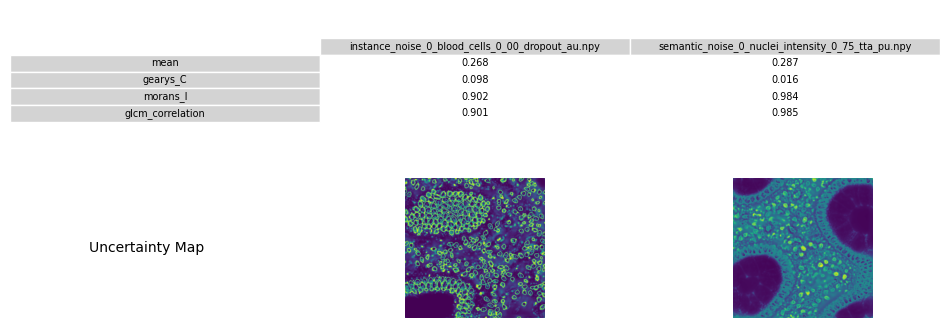

Name  instance_noise_0_blood_cells_0_00_dropout_au.npy  \
0              mean                                          0.268395   
1          gearys_C                                          0.097541   
2          morans_I                                          0.902148   
3  glcm_correlation                                          0.900985   

   semantic_noise_0_nuclei_intensity_0_75_tta_pu.npy  
0                                           0.287013  
1                                           0.015837  
2                                           0.983603  
3                                           0.984700

In [37]:
# Plot heatmaps having similar mean but different spatial metric scores:

print("Example for Geary's C")
min_max_files = min_max_heatmap("gearys_C", 0.2, 0.3)
min_max_unc_maps = [unc_map for unc_map in unc_maps if unc_map.name in min_max_files]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="min_max_gearys_C")
summary.apply_methods(min_max_unc_maps, save_to_excel=False, do_plot=True, max_value=1.0)


Example for Geary's C


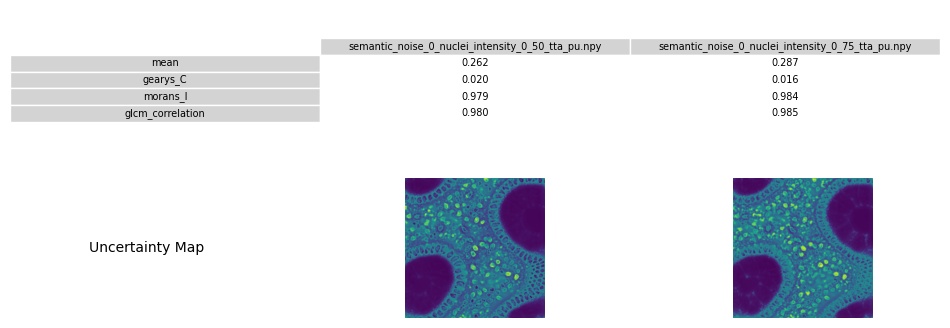

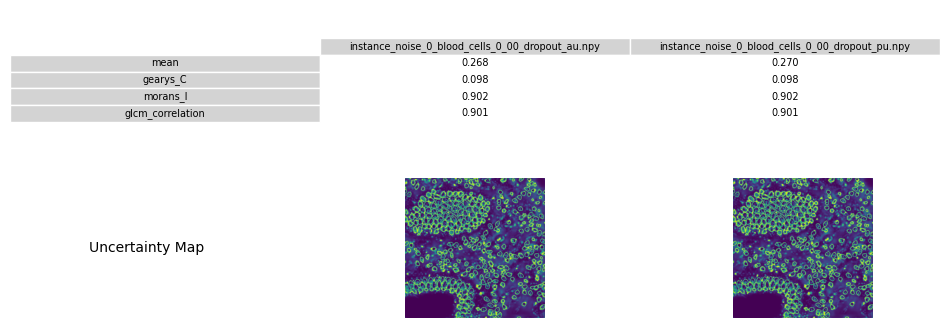

Name  instance_noise_0_blood_cells_0_00_dropout_au.npy  \
0              mean                                          0.268395   
1          gearys_C                                          0.097541   
2          morans_I                                          0.902148   
3  glcm_correlation                                          0.900985   

   instance_noise_0_blood_cells_0_00_dropout_pu.npy  
0                                          0.270142  
1                                          0.097528  
2                                          0.902181  
3                                          0.900982

In [38]:
# Plot heatmaps having similar mean but different spatial metric scores:

print("Example for Geary's C")
sorted_maps = sorted_heatmaps_by_mean("gearys_C", 0.2, 0.3)
min_maps = [unc_map for unc_map in unc_maps if unc_map.name in list(sorted_maps.keys())[:2]]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="Minimal Gearys")
summary.apply_methods(min_maps, save_to_excel=False, do_plot=True, max_value=1.0)


# Max
max_maps = [unc_map for unc_map in unc_maps if unc_map.name in list(sorted_maps.keys())[-2:]]

strategy_list = [(am.mean, None), (am.gearys_C, None), (am.morans_I, None), (am.glcm_correlation, None)]
summary = AggregationSummary(strategy_list, name="Maximal Gearys")
summary.apply_methods(max_maps, save_to_excel=False, do_plot=True, max_value=1.0)





1) 'semantic_noise_0_nuclei_intensity_1_00_tta_pu.npy_4_0.npy',
 'instance_noise_0_blood_cells_0_00_softmax_pu.npy_5_7.npy'

## Analysis of Noise Levels

In [28]:
def filter_filenames(filenames, keywords):
    return [f for f in filenames if all(kw in f for kw in keywords)]

import re
def extract_noise_level(filename):
    """
    Extracts the noise level from a filename and converts it to a float.

    :param filename: String representing the filename.
    :return: Float noise level or None if not found.
    """
    match = re.search(r'_(\d+)_(\d+)_', filename)
    if match:
        return float(f"{match.group(1)}.{match.group(2)}")
    return None  # Return None if no match found
    

blood_cell_files = filter_filenames(filenames, ['blood_cells'])
TO_LEVEL = {0.0: "0_00",
            0.25: "0_25",
            0.5: "0_50",
            0.75: "0_75",
            1.0: "1_00"}
levels = list(TO_LEVEL.keys())
blood_cell_files_by_level = {level: [file for file in blood_cell_files if extract_noise_level(file) == level] for level in levels}
blood_cell_files_by_level

{0.0: ['instance_noise_0_blood_cells_0_00_dropout_au.npy',
  'instance_noise_0_blood_cells_0_00_dropout_eu.npy',
  'instance_noise_0_blood_cells_0_00_dropout_pu.npy',
  'instance_noise_0_blood_cells_0_00_ensemble_au.npy',
  'instance_noise_0_blood_cells_0_00_ensemble_eu.npy',
  'instance_noise_0_blood_cells_0_00_ensemble_pu.npy',
  'instance_noise_0_blood_cells_0_00_softmax_pu.npy',
  'instance_noise_0_blood_cells_0_00_tta_au.npy',
  'instance_noise_0_blood_cells_0_00_tta_eu.npy',
  'instance_noise_0_blood_cells_0_00_tta_pu.npy',
  'semantic_noise_0_blood_cells_0_00_dropout_au.npy',
  'semantic_noise_0_blood_cells_0_00_dropout_eu.npy',
  'semantic_noise_0_blood_cells_0_00_dropout_pu.npy',
  'semantic_noise_0_blood_cells_0_00_ensemble_au.npy',
  'semantic_noise_0_blood_cells_0_00_ensemble_eu.npy',
  'semantic_noise_0_blood_cells_0_00_ensemble_pu.npy',
  'semantic_noise_0_blood_cells_0_00_softmax_pu.npy',
  'semantic_noise_0_blood_cells_0_00_tta_au.npy',
  'semantic_noise_0_blood_cells_0

In [66]:

def plot_grouped_boxplots(data, methods, levels, title=None):
    """
    Creates a single plot with m groups, each containing l boxplots (one per level).

    :param data: Dictionary with keys as (method, level) tuples and values as lists of values.
    :param methods: List of method names (m methods).
    :param levels: List of level names (l levels).
    """
    m = len(methods)  # Number of method groups
    l = len(levels)  # Number of levels per method

    fig, ax = plt.subplots(figsize=(6 + m, 6))

    positions = []  # Stores x-positions of each boxplot
    box_data = []  # Stores corresponding data
    width = 0.15  # Width of each boxplot
    spacing = 0.75  # Spacing between method groups

    cmap = plt.get_cmap("Reds")
    colors = [cmap(level) for level in levels]

    for method_idx, method in enumerate(methods):
        base_pos = method_idx * (l * width + spacing)  # Base position for this method
        for level_idx, level in enumerate(levels):
            positions.append(base_pos + level_idx * width)  # Adjust x position per level
            box_data.append(data[(method, level)])

    # Create the boxplot
    box = ax.boxplot(box_data, vert=True, positions=positions, widths=width, patch_artist=True)

    # Apply colors per level
    for patch, level_idx in zip(box["boxes"], [i % l for i in range(len(box_data))]):
        patch.set_facecolor(colors[level_idx])

    # Create x-tick labels for methods
    tick_positions = [method_idx * (l * width + spacing) + (l * width) / 2 for method_idx in range(m)]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(methods, rotation=45, ha="right")

    ax.set_ylabel("Values")
    title = title if title else "Grouped Boxplots per Method with Levels"
    ax.set_title(title)

    # Create a legend
    legend_patches = [plt.Line2D([0], [0], color=color, lw=4, label=level) for color, level in zip(colors, levels)]
    ax.legend(handles=legend_patches, title="Noise", loc="lower right")

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# methods = ["Method A", "Method B", "Method C"]
# levels = ["Level 1", "Level 2", "Level 3"]
# data = {
#     ("Method A", "Level 1"): np.random.rand(50),
#     ("Method A", "Level 2"): np.random.rand(50),
#     ("Method A", "Level 3"): np.random.rand(50),
#     ("Method B", "Level 1"): np.random.rand(50),
#     ("Method B", "Level 2"): np.random.rand(50),
#     ("Method B", "Level 3"): np.random.rand(50),
#     ("Method C", "Level 1"): np.random.rand(50),
#     ("Method C", "Level 2"): np.random.rand(50),
#     ("Method C", "Level 3"): np.random.rand(50),
# }

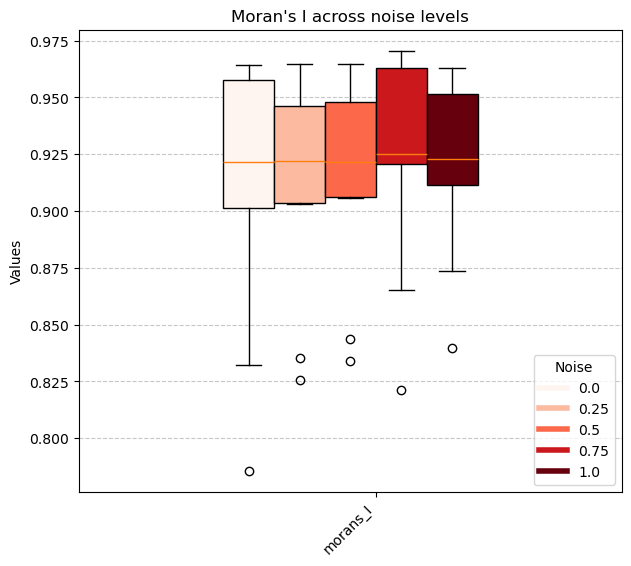

In [74]:
methods = ["morans_I"]
data = {}
for method in methods:
    for level in levels:
        method_values = spatial_df[blood_cell_files_by_level[level]][spatial_df["Name"] == method].values
        #print(method_values)
        data[(method, level)] = method_values[0]
        
plot_grouped_boxplots(data, methods, levels, title="Moran's I across noise levels")

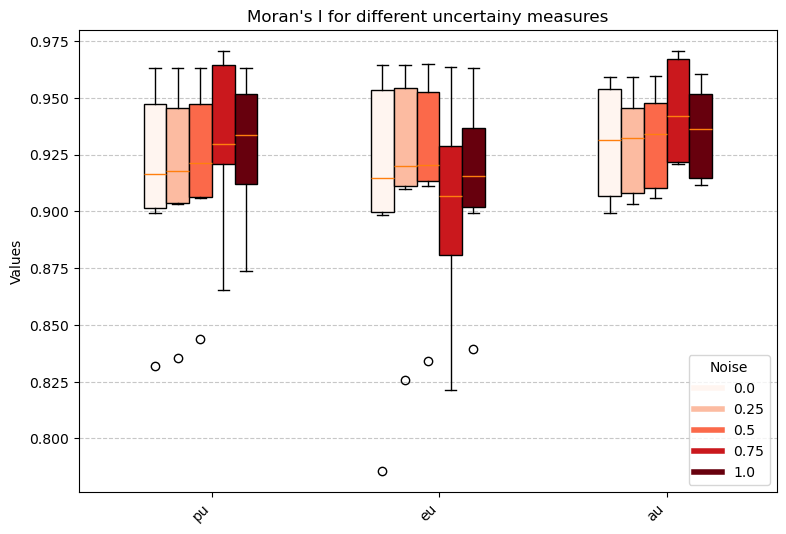

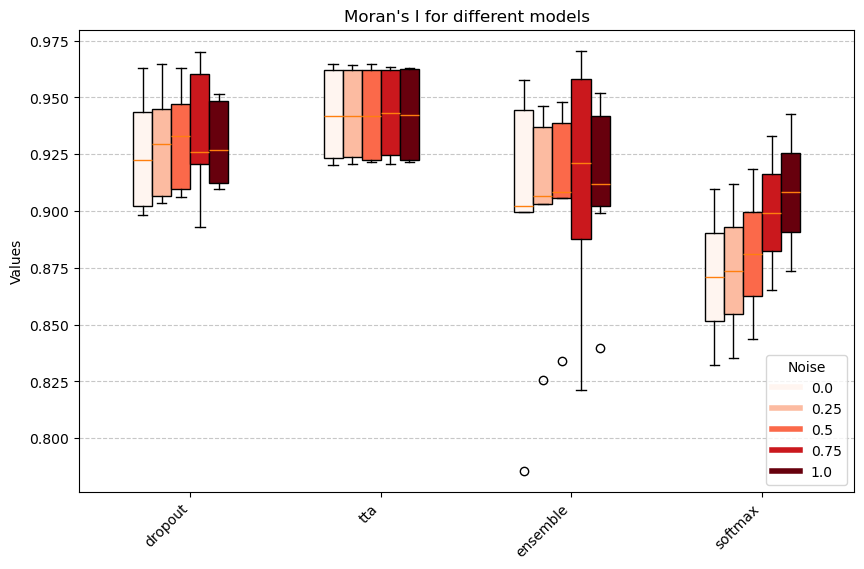

In [69]:
uqs = ["pu", "eu", "au"]
models = ["dropout", "tta", "ensemble", "softmax"]
methods = list(spatial_df["Name"])

def make_data(focus_list):
    data = {}
    for focus_type in focus_list:
        for level in levels:
            focus_files = [file for file in blood_cell_files_by_level[level] if focus_type in file]
            focus_values = spatial_df[focus_files][spatial_df["Name"] == "morans_I"].values
            #print(method_values)
            data[(focus_type, level)] = focus_values[0]
    return data
        
plot_grouped_boxplots(make_data(uqs), uqs, levels, title="Moran's I for different uncertainy measures")
plot_grouped_boxplots(make_data(models), models, levels, title="Moran's I for different models")

C:\Users\ckarg\AppData\Local\Temp\ipykernel_11628\2421877906.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("Reds")


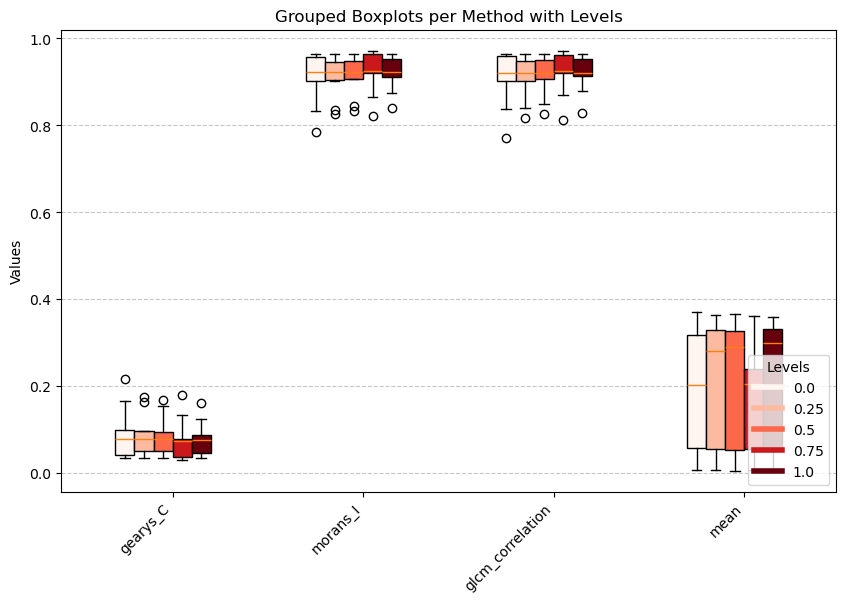

In [61]:
methods = list(spatial_df["Name"])
data = {}
for method in methods:
    for level in levels:
        method_values = spatial_df[blood_cell_files_by_level[level]][spatial_df["Name"] == method].values
        #print(method_values)
        data[(method, level)] = method_values[0]
        
plot_grouped_boxplots(data, methods, levels)